<div class="jumbotron">
  <h1 class="display-3">First (basic) lesson with Abinit and AbiPy</h1>
  <p class="lead">The H<sub>2</sub> molecule</p> 
  <hr class="my-4">
  <p>This lesson aims at showing how to get the following physical properties:</p>
      
   <ul>
    <li>the (pseudo) total energy</li>
    <li>the bond length</li>
    <li>the charge density</li>
    <li>the atomisation energy</li>
   </ul>
   
<p>You will learn about the two input files, the basic input variables, the existence of defaults, the actions of the 
   parser, and the use of the multi-dataset feature. You will also learn about the two output files as well as the 
   density file. This first lesson covers the sections 1, 3, 4 and 6 of the abinit help file.
</p>
<p>
The very first step is a detailed tour of the input and output files: you are like a tourist, and you discover a town in a coach. You will have a bit more freedom after that first step. I
t is supposed that you have some good knowledge of UNIX/Linux.
</p>
  <p class="lead">
    <a class="btn btn-primary btn-lg" href="#" role="button">Learn more</a>
  </p>
</div>

There are three methodologies to compute the optimal distance between the two Hydrogen atoms. One could:

   * compute the **total energy** for different values of the interatomic distance, make a fit through 
      the different points, and determine the minimum of the fitting function;
   * compute the **forces** for different values of the interatomic distance, make a fit through 
      the different values, and determine the zero of the fitting function;
   * use an automatic algorithm for minimizing the energy (or finding the zero of forces)

We will begin with the computation of energy and forces for different values of the interatomic distance. 
This exercise will allow us to learn how to use generate multiple input files with AbiPy and analyze multiple runs 
with the AbiPy robots.


The interatomic distance in the tbase1_1.in file was 1.4 Bohr. Suppose you decide to examine the interatomic distances from 1.0 Bohr to 2.0 Bohr, by steps of 0.05 Bohr. That is, 21 calculations.
If you are a UNIX guru, it will be easy for you to write a script that will drive these 21 calculations, changing automatically the variable xcart in the input file, and then gather all the data, in a convenient form to be plotted.
Well, are you a UNIX guru? If not, there is an easier path, all within ABINIT!

This is the multi-dataset mode. Detailed explanations about it can be found in sections 3.3, 3.4, 3.5 and 3.6, of the abinit help file.

Now, can you write an input file that will do the computation described above (interatomic distances from 1.0 Bohr to 2.0 Bohr, by steps of 0.05 Bohr)? You might start from tbase1_1.in. Try to define a series, and to use the getwfk input variable (the latter will make the computation much faster).

You should likely have a look at the section that describes the irdwfk and getwfk input variables: in particular, look at the meaning of getwfk -1

Also, define explicitly the number of states (or supercell “bands”) to be one, using the input variable nband.

## Our first python function

In [91]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import print_function, division, unicode_literals

import numpy as np
import seaborn

from abipy import abilab

# This line tells the notebook to show plots inside of the notebook
%matplotlib notebook

Now we need a function that generates an input file for a SCF-GS calculation of $H_2$ in a big box.
Ideally we would like a function that receives some arguments so that we can change the input variables
and generate multiple inputs easily.

Fortunately we already have such a function in the `mkflow.py` module.
Let's import it and look at the code.

In [92]:
from lesson_base1 import gs_input
abilab.print_source(gs_input)

If the function is called without arguments, default values are used. Let's try:

In [93]:
inp = gs_input()
print("ecut", inp["ecut"])

ecut 10


`inp` is a dict-like object but, as we are working inside a notebook, we can look at its HTML representation:

In [94]:
inp

<AbinitInput at 4808659576>

The input object can be converted into an Abinit input string. 
More importantly, an input *has* an AbiPy structure (actually a subclass of pymatgen structure), 
a list of pseudopotential objects and provides several methods that are quite handy for the generation of our inputs.

In [95]:
print(inp.structure)
print("The big box volume is:", inp.structure.volume)

Full Formula (H2)
Reduced Formula: H2
abc   :   5.291772   5.291772   5.291772
angles:  90.000000  90.000000  90.000000
Sites (2)
  #  SP        a    b    c
---  ----  -----  ---  ---
  0  H     -0.07    0    0
  1  H      0.07    0    0
The big box volume is: 148.184711276


Let's get some info about our pseudopotential:

In [96]:
print(inp.pseudos[0])

<NcAbinitPseudo: 01h.pspgth>
  summary: Goedecker-Teter-Hutter  Wed May  8 14:27:44 EDT 1996
  number of valence electrons: 1.0
  maximum angular momentum: s
  angular momentum for local part: s
  XC correlation: LDA_XC_TETER93
  supports spin-orbit: False
  radius for non-linear core correction: 0.0
  hint for low accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for normal accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for high accuracy: ecut: 0.0, pawecutdg: 0.0


<div class="alert alert-danger">
Blah blah blah
</div>

## Computation of the interatomic distance (method 1)

At this point, we need a function that uses the input returned by `gs_input` to generate some kind of object
that can be used by python to invoke Abinit that in turns will run the calculations.

We have already prepared such a function in `build_flow`

In [97]:
from lesson_base1 import build_flow
abilab.print_source(build_flow)

Ok, so far so sood. With just three lines of codes and our `gs_input` function, we managed 
to construct an AbiPy flow for the $H_2$ molecule.

Now we could run the flow in the notebook by just calling `flow.make_scheduler().start()` but 
we postpone the discussion of this part because we should first configure AbiPy with two Yaml files
with options defining the execution environment and the submission policy.

For the time being, we assume the flow has been already executed and we focus on the analysis of the results.
There are only two points that we need to understand before proceeding with the next sections:

* A `Flow` is a list of `Worflows` objects and each `Workflow` is a list of `Tasks`
* Each `Task` is associated to an `AbinitInput` object and tasks are executed in different directories with a predefined structure.


Armed with these concepts, we can finally start to use `abiopen` to analyze the output files of our `Flow`.

### abiopen


`abiopen` provides a unified interface to the different output files produced by Abinit 
and it also has a command line interface (`abiopen.py`).

Just call it with the path to the file and save the returned value:  

In [98]:
abo = abilab.abiopen("flow_h2/w0/t0/run.abo")
print(abo)

ndtset: 1, completed: True
Full Formula (H2)
Reduced Formula: H2
abc   :   5.291772   5.291772   5.291772
angles:  90.000000  90.000000  90.000000

Spglib space group info (magnetic symmetries are not taken into account).
Spacegroup: P4/mmm (123), Hall: -P 4 2, Abinit spg_number: 123
Crystal_system: tetragonal, Lattice_type: tetragonal, Point_group: 4/mmm

  Idx  Symbol    Reduced_Coords              Wyck      EqIdx
-----  --------  --------------------------  ------  -------
    0  H         -0.05000 +0.00000 +0.00000  g             0
    1  H         +0.05000 +0.00000 +0.00000  g             0

Abinit Spacegroup: spgid: 123, num_spatial_symmetries: 16, has_timerev: True, symmorphic: False


In [99]:
# This is WRONG

In [100]:
print(abo.events)

Events found in /Users/gmatteo/git_repos/abitutorials/abitutorials/base1/flow_h2/w0/t0/run.abo

num_errors: 0, num_warnings: 0, num_comments: 0, completed: False



In [101]:
abo.initial_structure == abo.final_structure

True

To plot the GS-SCF cycle, use:

<IPython.core.display.Javascript object>


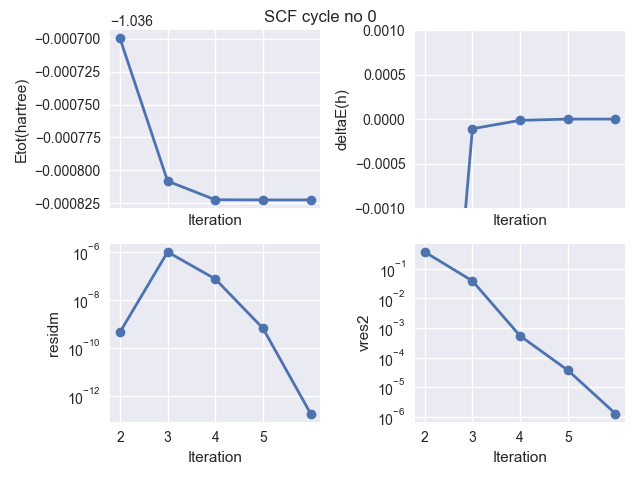

exception while parsing file /Users/gmatteo/git_repos/abitutorials/abitutorials/base1/flow_h2/w0/t0/run.abo:
/Users/gmatteo/git_repos/abitutorials/abitutorials/base1/flow_h2/w0/t0/run.abo: No timer section found


In [102]:
abo.plot();

### GSR file

The output file is a text file and Abipy tries to do its best to extract useful results from it.
Still, there are several quantities we would link to get at the end of the run and the format of the output file
is not machine-friendly.

This is the reason why we usually use netcdf files to extract data in python.
The GS results, in particular, are saved in the `GSR.nc` (GSR stands for Ground-State Results) and, obviously, 
we can open it `abiopen`:

In [103]:
with abilab.abiopen("flow_h2/w0/t0/outdata/out_GSR.nc") as gsr:
    print(gsr)

================================= File Info =================================
Name: out_GSR.nc
Directory: /Users/gmatteo/git_repos/abitutorials/abitutorials/base1/flow_h2/w0/t0/outdata
Size: 8.20 kb
Access Time: Wed Oct 11 20:11:49 2017
Modification Time: Tue Oct 10 21:27:35 2017
Change Time: Tue Oct 10 21:27:35 2017

================================= Structure =================================
Full Formula (H2)
Reduced Formula: H2
abc   :   5.291772   5.291772   5.291772
angles:  90.000000  90.000000  90.000000
Sites (2)
  #  SP        a    b    c  cartesian_forces
---  ----  -----  ---  ---  --------------------------------------------------
  0  H     -0.05    0    0  [-19.54779666  -0.          -0.        ] eV ang^-1
  1  H      0.05    0    0  [ 19.54779666  -0.          -0.        ] eV ang^-1

Stress tensor (Cartesian coordinates in Ha/Bohr**3):
[[ -3.65644463e-04   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   5.46899250e-05   0.00000000e+00]
 [  0.00000000e+00   0.00000

We see that a `GSR` file contains information about the crystalline structure, the forces/stresses 
as well as the electronic band energies.
In the jargon of object-oriented programming, one says that a `GSR` file *has* a structure:
    
        gsr.structure
        
and *has* electron bands:
    
        gsr.ebands
        
Thist means that if you learn how to use the methods provided by `structure` and `ebands` than you can 
easily get these objects from the `GSR` file and use this API to post-process the results.

This is a general philosophy of AbiPy: every netcdf file object returned by `abiopen` contains
other objects (the structure is always available, while the presence of other objects depend of the file type). 
Remember this point because we'll use it the other lessons.

### robots and pandas DataFrames

Ok, now we know how to open and extract information from one GSR file but, in this particular
case, we need to analyze multiple GSR file!

If you are familiar with python, it should not be so difficult to write a `for loop` that 
iterates over a list of GSR files, extracts the total energy and the volume and creates two
lists than can used to plot $E(V)$.
This kind of operations are, however, very common and AbiPy provides a high-level interface (`robots`) to
operate on multiple files and post-process the data.

In the simplest case, the `Robot` finds all files of a particula type located within a directory tree,
stores all the data in memory and exposes methods to extract/post-process the results.

In [104]:
with abilab.GsrRobot.from_dir("flow_h2") as robot:
    table = robot.get_dataframe()

The table has several columns

In [105]:
table.keys()

Index(['energy', 'pressure', 'max_force', 'ecut', 'pawecutdg', 'tsmear',
       'nkpt', 'nsppol', 'nspinor', 'nspden', 'formula', 'natom', 'angle0',
       'angle1', 'angle2', 'a', 'b', 'c', 'volume', 'abispg_num',
       'spglib_symb', 'spglib_num'],
      dtype='object')

In [106]:
table

energy  pressure  max_force  ecut  \
flow_h2/w0/t0/outdata/out_GSR.nc  -28.213374  2.513190  19.547797  10.0   
flow_h2/w0/t1/outdata/out_GSR.nc  -28.697681  1.960241  15.457585  10.0   
flow_h2/w0/t10/outdata/out_GSR.nc -30.091282 -1.106893   0.050198  10.0   
flow_h2/w0/t11/outdata/out_GSR.nc -30.081045 -1.306065   0.669857  10.0   
flow_h2/w0/t12/outdata/out_GSR.nc -30.054897 -1.486644   1.198657  10.0   
flow_h2/w0/t13/outdata/out_GSR.nc -30.015128 -1.650522   1.652942  10.0   
flow_h2/w0/t14/outdata/out_GSR.nc -29.963621 -1.799430   2.045489  10.0   
flow_h2/w0/t15/outdata/out_GSR.nc -29.901949 -1.934775   2.386232  10.0   
flow_h2/w0/t16/outdata/out_GSR.nc -29.831440 -2.058170   2.682742  10.0   
flow_h2/w0/t17/outdata/out_GSR.nc -29.753241 -2.170736   2.940714  10.0   
flow_h2/w0/t18/outdata/out_GSR.nc -29.668361 -2.273620   3.164346  10.0   
flow_h2/w0/t19/outdata/out_GSR.nc -29.577707 -2.367716   3.356837  10.0   
flow_h2/w0/t2/outdata/out_GSR.nc  -29.079272  1.463279  12.125932  10.0   
flow_h2/w0/t20/outdata/out_GSR.nc -29.482112 -2.453930   3.520449  10.0   
flow_h2/w0/t3/outdata/out_GSR.nc  -29.377087  1.016115   9.404751  10.0   
flow_h2/w0/t4/outdata/out_GSR.nc  -29.606392  0.612993   7.176415  10.0   
flow_h2/w0/t5/outdata/out_GSR.nc  -29.779514  0.249295   5.346041  10.0   
flow_h2/w0/t6/outdata/out_GSR.nc  -29.906409 -0.079134   3.837290  10.0   
flow_h2/w0/t7/outdata/out_GSR.nc  -29.995127 -0.375909   2.588480  10.0   
flow_h2/w0/t8/outdata/out_GSR.nc  -30.052173 -0.644270   1.549818  10.0   
flow_h2/w0/t9/outdata/out_GSR.nc  -30.082807 -0.887079   0.681054  10.0   

                                   pawecutdg  tsmear  nkpt  nsppol  nspinor  \
flow_h2/w0/t0/outdata/out_GSR.nc        -1.0    0.01     1       1        1   
flow_h2/w0/t1/outdata/out_GSR.nc        -1.0    0.01     1       1        1   
flow_h2/w0/t10/outdata/out_GSR.nc       -1.0    0.01     1       1        1   
flow_h2/w0/t11/outdata/out_GSR.nc       -1.0    0.01     1       1        1   
flow_h2/w0/t12/outdata/out_GSR.nc       -1.0    0.01     1       1        1   
flow_h2/w0/t13/outdata/out_GSR.nc       -1.0    0.01     1       1        1   
flow_h2/w0/t14/outdata/out_GSR.nc       -1.0    0.01     1       1        1   
flow_h2/w0/t15/outdata/out_GSR.nc       -1.0    0.01     1       1        1   
flow_h2/w0/t16/outdata/out_GSR.nc       -1.0    0.01     1       1        1   
flow_h2/w0/t17/outdata/out_GSR.nc       -1.0    0.01     1       1        1   
flow_h2/w0/t18/outdata/out_GSR.nc       -1.0    0.01     1       1        1   
flow_h2/w0/t19/outdata/out_GSR.nc       -1.0    0.01     1       1        1   
flow_h2/w0/t2/outdata/out_GSR.nc        -1.0    0.01     1       1        1   
flow_h2/w0/t20/outdata/out_GSR.nc       -1.0    0.01     1       1        1   
flow_h2/w0/t3/outdata/out_GSR.nc        -1.0    0.01     1       1        1   
flow_h2/w0/t4/outdata/out_GSR.nc        -1.0    0.01     1       1        1   
flow_h2/w0/t5/outdata/out_GSR.nc        -1.0    0.01     1       1        1   
flow_h2/w0/t6/outdata/out_GSR.nc        -1.0    0.01     1       1        1   
flow_h2/w0/t7/outdata/out_GSR.nc        -1.0    0.01     1       1        1   
flow_h2/w0/t8/outdata/out_GSR.nc        -1.0    0.01     1       1        1   
flow_h2/w0/t9/outdata/out_GSR.nc        -1.0    0.01     1       1        1   

                                   nspden    ...     angle0  angle1  angle2  \
flow_h2/w0/t0/outdata/out_GSR.nc        1    ...       90.0    90.0    90.0   
flow_h2/w0/t1/outdata/out_GSR.nc        1    ...       90.0    90.0    90.0   
flow_h2/w0/t10/outdata/out_GSR.nc       1    ...       90.0    90.0    90.0   
flow_h2/w0/t11/outdata/out_GSR.nc       1    ...       90.0    90.0    90.0   
flow_h2/w0/t12/outdata/out_GSR.nc       1    ...       90.0    90.0    90.0   
flow_h2/w0/t13/outdata/out_GSR.nc       1    ...       90.0    90.0    90.0   
flow_h2/w0/t14/outdata/out_GSR.nc       1    ...       90.0    90.0    90.0   
flow_h2/w0/t15/o

In [107]:
table["volume"] == table["volume"][0]

flow_h2/w0/t0/outdata/out_GSR.nc     True
flow_h2/w0/t1/outdata/out_GSR.nc     True
flow_h2/w0/t10/outdata/out_GSR.nc    True
flow_h2/w0/t11/outdata/out_GSR.nc    True
flow_h2/w0/t12/outdata/out_GSR.nc    True
flow_h2/w0/t13/outdata/out_GSR.nc    True
flow_h2/w0/t14/outdata/out_GSR.nc    True
flow_h2/w0/t15/outdata/out_GSR.nc    True
flow_h2/w0/t16/outdata/out_GSR.nc    True
flow_h2/w0/t17/outdata/out_GSR.nc    True
flow_h2/w0/t18/outdata/out_GSR.nc    True
flow_h2/w0/t19/outdata/out_GSR.nc    True
flow_h2/w0/t2/outdata/out_GSR.nc     True
flow_h2/w0/t20/outdata/out_GSR.nc    True
flow_h2/w0/t3/outdata/out_GSR.nc     True
flow_h2/w0/t4/outdata/out_GSR.nc     True
flow_h2/w0/t5/outdata/out_GSR.nc     True
flow_h2/w0/t6/outdata/out_GSR.nc     True
flow_h2/w0/t7/outdata/out_GSR.nc     True
flow_h2/w0/t8/outdata/out_GSR.nc     True
flow_h2/w0/t9/outdata/out_GSR.nc     True
Name: volume, dtype: bool

Great, we managed to get a nice table with lot of useful results with just 3 lines of code and the robot!
There are however two problems:
    
   - The rows of the table are not ordered by volume (files are sorted alphabetically)
   
   - Our dataframe contains the energy of the different configurations but we would like to plot energy 
     vs the H-H distance
   
Well, robots can do a lot of hard work but they are a little bit stupid so we have to tell them what to do with the data. More specifically we need a way to tell the robot that for each GSR file, it should get the crystalline 
structure, compute the distance between the first and the second atom and insert the result in our table 
in a given column. 

This kind of tasks are usually executed with `callbacks` i.e. functions that are passed as argument 
and executed by the framework at runtime. Let's look at the doc string of `get_dataframe`:

In [108]:
help(robot.get_dataframe)

Help on method get_dataframe in module abipy.abio.robots:

get_dataframe(with_geo=True, abspath=False, **kwargs) method of abipy.abio.robots.GsrRobot instance
    Return a pandas DataFrame with the most important GS results.
    and the filenames as index.
    
    Args:
        with_geo: True if structure info should be added to the dataframe
        abspath: True if paths in index should be absolute. Default: Relative to getcwd().
    
    kwargs:
        attrs:
            List of additional attributes of the :class:`GsrFile` to add to
            the pandas :class:`DataFrame`
        funcs:
            Function or list of functions to execute to add more data to the DataFrame.
            Each function receives a :class:`GsrFile` object and returns a tuple (key, value)
            where key is a string with the name of column and value is the value to be inserted.



It seems a little bit complicated but the actual implementation has more comments that code:

In [109]:
def hh_dist(gsr):
    """
    This callback receives a GSR file and computes the H-H distance.
    The robot will call this function to compute the H-H distance, 
    and return a (key, value) tuple that will be inserted in the pandas DataFrame.
    """
    cart_coords = gsr.structure.cart_coords
    l = np.linalg.norm(cart_coords[1] - cart_coords[0])
    return "hh_dist", l

with abilab.GsrRobot.from_dir("flow_h2") as robot:
    table = robot.get_dataframe(funcs=hh_dist)
    table = table.sort_values(by="hh_dist")  

As expected, not the table contains a new column with `hh_dist` in Angstrom:

In [110]:
"hh_dist" in table.keys()

True

Let's print the two columns with the H-H distance and the total energy:

In [111]:
table[["hh_dist", "energy"]]

hh_dist     energy
flow_h2/w0/t0/outdata/out_GSR.nc   0.529177 -28.213374
flow_h2/w0/t1/outdata/out_GSR.nc   0.556959 -28.697681
flow_h2/w0/t2/outdata/out_GSR.nc   0.584741 -29.079272
flow_h2/w0/t3/outdata/out_GSR.nc   0.612523 -29.377087
flow_h2/w0/t4/outdata/out_GSR.nc   0.640304 -29.606392
flow_h2/w0/t5/outdata/out_GSR.nc   0.668086 -29.779514
flow_h2/w0/t6/outdata/out_GSR.nc   0.695868 -29.906409
flow_h2/w0/t7/outdata/out_GSR.nc   0.723650 -29.995127
flow_h2/w0/t8/outdata/out_GSR.nc   0.751432 -30.052173
flow_h2/w0/t9/outdata/out_GSR.nc   0.779213 -30.082807
flow_h2/w0/t10/outdata/out_GSR.nc  0.806995 -30.091282
flow_h2/w0/t11/outdata/out_GSR.nc  0.834777 -30.081045
flow_h2/w0/t12/outdata/out_GSR.nc  0.862559 -30.054897
flow_h2/w0/t13/outdata/out_GSR.nc  0.890341 -30.015128
flow_h2/w0/t14/outdata/out_GSR.nc  0.918122 -29.963621
flow_h2/w0/t15/outdata/out_GSR.nc  0.945904 -29.901949
flow_h2/w0/t16/outdata/out_GSR.nc  0.973686 -29.831440
flow_h2/w0/t17/outdata/out_GSR.nc  1.001468 -29.753241
flow_h2/w0/t18/outdata/out_GSR.nc  1.029250 -29.668361
flow_h2/w0/t19/outdata/out_GSR.nc  1.057031 -29.577707
flow_h2/w0/t20/outdata/out_GSR.nc  1.084813 -29.482112

Note that the energy in our DataFrame is given in eV in order to facilitate the integration 
with other pymatgen tools in which energies are in eV and lenghts are in Angstrom.

Let's add another column to our table with energies in Hartree:

In [112]:
table["energy_Ha"] = table["energy"] * abilab.units.eV_to_Ha

and use the pandas DataFrame `plot` method to plot `energy_Ha` vs `hh_dist`  

<IPython.core.display.Javascript object>


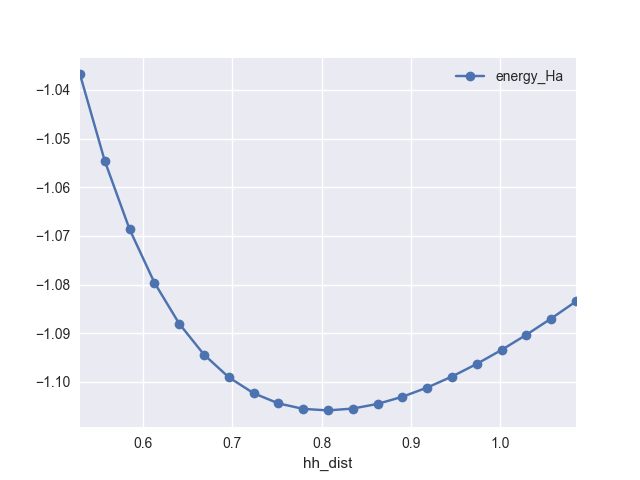

In [113]:
table.plot(x="hh_dist", y="energy_Ha", style="-o");

At this point, it should be clear that to plot the maximum of the forces as a function of the H-H distance
we just need:

<IPython.core.display.Javascript object>


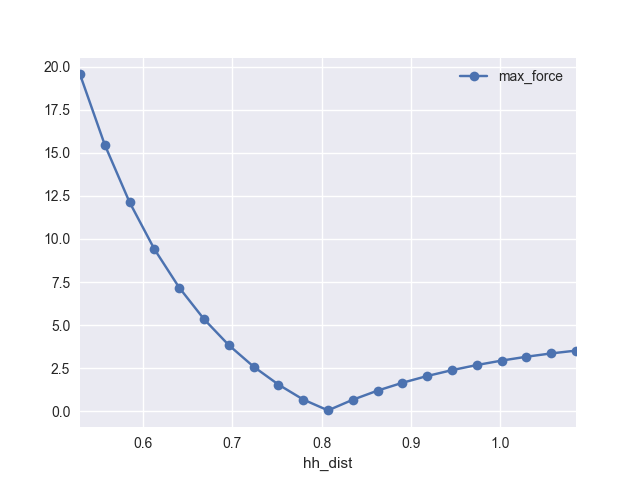

In [114]:
table.plot(x="hh_dist", y="max_force", style="-o");

Want to plot the two quantities on the same figure?

<IPython.core.display.Javascript object>


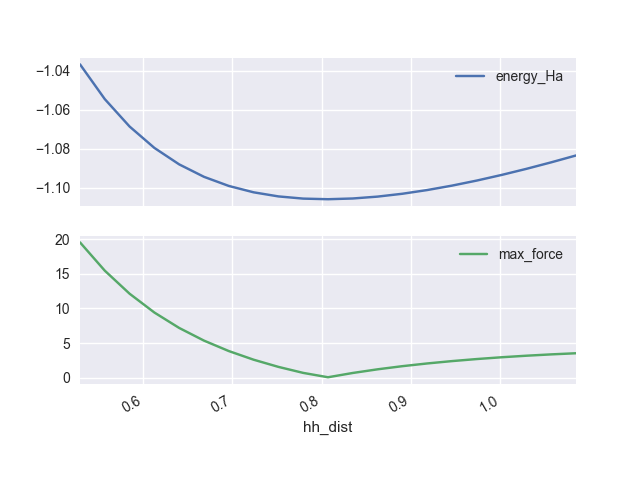

In [115]:
table.plot(x="hh_dist", y=["energy_Ha", "max_force"], subplots=True);

## Analysis of the charge density

The density in real space on the FFT mesh is stored in the `DEN.nc` file produced at the end of the GS-SCF cycle.
A `DEN.nc` file *has* a `structure`, an `ebands` object and `Density` object with $n(r)$ (stored in the 
numpy array `.datar`) and $n(G)$ (stored in `.datag`). 

Let's open the file with `abiopen` and print it:

In [116]:
with abilab.abiopen("flow_h2/w0/t10/outdata/out_DEN.nc") as denfile:
    print(denfile)
    density = denfile.density

================================= File Info =================================
Name: out_DEN.nc
Directory: /Users/gmatteo/git_repos/abitutorials/abitutorials/base1/flow_h2/w0/t10/outdata
Size: 217.43 kb
Access Time: Wed Oct 11 20:11:52 2017
Modification Time: Tue Oct 10 21:27:37 2017
Change Time: Tue Oct 10 21:27:37 2017

================================= Structure =================================
Full Formula (H2)
Reduced Formula: H2
abc   :   5.291772   5.291772   5.291772
angles:  90.000000  90.000000  90.000000
Sites (2)
  #  SP           a    b    c
---  ----  --------  ---  ---
  0  H     -0.07625    0    0
  1  H      0.07625    0    0

============================== Electronic Bands ==============================
Number of electrons: 2.0, Fermi level: -9.658 [eV]
nsppol: 1, nkpt: 1, mband: 1, nspinor: 1, nspden: 1
smearing scheme: none, tsmear_eV: 0.272, occopt: 1
Bandwidth: 0.000 [eV]
Valence minimum located at:
    spin=0, kpt=[+0.000, +0.000, +0.000], weight: 1.000, band=0, 

The simplest thinh we can do now is to print $n(r)$ along a line passing through two points specified 
either in terms of two vectors or two integers defining the site index in the `structure`.

Let's plot the density along the H-H bond by passing the index of the two atoms:

<IPython.core.display.Javascript object>


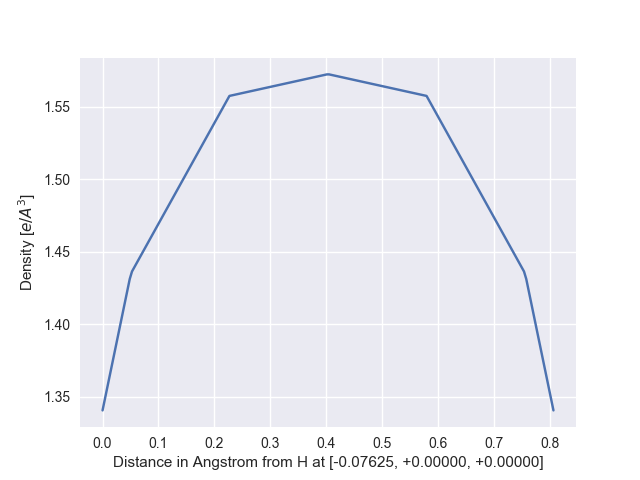

In [117]:
fig = density.plot_line(0, 1)

$n(r)$ is a 3d object and the notebook is not the most suitable tool to visualize objects in 3d.

Fortunately there are several graphical software to visualize fields in crystalline environments
and AbiPy provides tools to export the data to text files in formats supported by external graphical tools. 

In [118]:
print([m for m in dir(density)])

['__abs__', '__abstractmethods__', '__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_check_and_get_datar', '_check_space', '_datar', '_mesh', '_structure', 'ae_core_density_on_mesh', 'datag', 'datar', 'export', 'export_structure', 'export_to_cube', 'from_chgcar_poscar', 'from_cube', 'from_file', 'get_interpolator', 'get_nelect', 'integrate_in_spheres', 'is_collinear', 'is_density_like', 'is_potential_like', 'latex_label', 'magnetization', 'magnetization_field', 'mean', 'mesh', 'nelect_updown', 'netcdf_name', 'nspden', 'n

## Conclusions

To summarize, we learned how to define python functions that can be used to generate many input files easily.
We briefly discussed how to use these inputs to build a basic AbiPy flow without dependencies.
More importantly, we showed that AbiPy provides several tools that can be used to inspect and analyze 
the results without having to pass necessarly through the creation and execution of the `Flow`.
Last but not least, we discussed how to use robots to collect results from the output files and store 
them in pandas DataFrames

Indeed, AbiPy users are **strongly recommended** to familiarize themself with this kind of interface before
moving to more advanced features such as flow execution that requires a good understanding of the python language.

As a matter of fact, we decided to write AbiPy in python not for efficiency reasons (actually python 
is usually slower that Fortran/C) but because there are tons of libraries for scientific applications 
(numpy, scipy, pandas, matplotlib, jupyter, etc).
If you learn to use these great libraries for your work you can really boost your productivity and save a lot of time.

## Exercises

In [119]:
!abiopen.py --help

usage: abiopen.py [-h] [--loglevel LOGLEVEL] [-V] [-v] [-nb] [--foreground]
                  [-p]
                  filepath

positional arguments:
  filepath             File to open. See table below for the list of supported
                       extensions.

optional arguments:
  -h, --help           show this help message and exit
  --loglevel LOGLEVEL  Set the loglevel. Possible values: CRITICAL, ERROR
                       (default), WARNING, INFO, DEBUG
  -V, --version        show program's version number and exit
  -v, --verbose        verbose, can be supplied multiple times to increase
                       verbosity
  -nb, --notebook      Open file in jupyter notebook
  --foreground         Run jupyter notebook in the foreground.
  -p, --print          Print python object and return.

Usage example:

    abiopen.py FILE        => Open file in ipython shell.
    abiopen.py FILE -nb       => Generate jupyter notebook.
    abiopen.py FILE -p    => Print info on object to ter